In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

In [2]:
#Loading Energy consumption Dataset
#file = files.upload()
df = pd.read_csv("energydata_complete.csv",sep=',')
#printing the head of the Dataset
df=df.drop(['date'], axis=1) #Dropping Date Column in the Dataset
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [0]:
#Converting Energy consumption into a Binary Classification Problem
df['Appliances']=(df['Appliances']>int(df['Appliances'].mean())).astype(int)
#Splitting x and y
y=df['Appliances'].values
X=df.drop(['Appliances'], axis=1).values
#X=df[['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',]].values
#Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,random_state=100)

In [0]:
def featureNormalize(X):
    X_norm = X
    mu    = np.zeros((1, X.shape[1]))
    sigma = np.zeros((1, X.shape[1]))
    for i in range(X.shape[1]):
      mu[:,i] = np.mean(X[:,i])
      sigma[:,i] = np.std(X[:,i])
      X_norm[:,i] = (X[:,i] - float(mu[:,i]))/float(sigma[:,i])
    return X_norm, mu, sigma

In [0]:
X_norm, mu, sigma = featureNormalize(X_train)
X_train = X_norm
X_test = (X_test - mu)/sigma

In [0]:
k_range = range(1,26)
scores_train=[]
scores_test=[]
scores_list =[]

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train,y_train)
  y_pred_train = knn.predict(X_train)
  scores_train.append(metrics.accuracy_score(y_train,y_pred_train))
  y_pred_test = knn.predict(X_test)
  scores_test.append(metrics.accuracy_score(y_test,y_pred_test))

In [0]:
df1 = pd.DataFrame(
    {'K-Neighbor': k_range,
     'Acc': 'Training Accuracy',
     'Accuracy': scores_train
    })
df2 = pd.DataFrame(
    {'K-Neighbor': k_range,
     'Acc': 'Testing Accuracy',
     'Accuracy': scores_test
    })

df_knn = pd.concat([df1, df2],sort=False)
df_knn['Accuracy'] = (df_knn['Accuracy'] * 100).round(2)

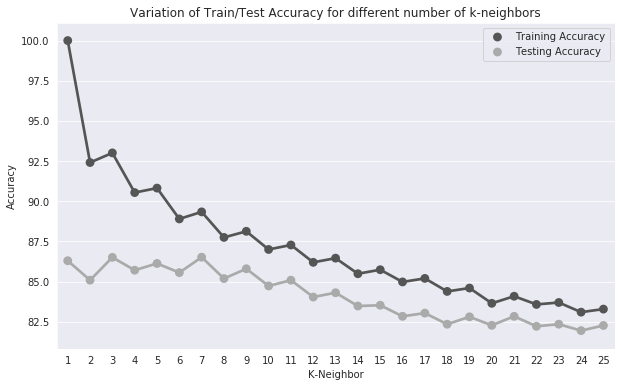

In [8]:
sns.set_style("darkgrid",
              {
                  'axes.grid' : True
              })
plt.figure(figsize=(10,6))
ax = sns.pointplot(x="K-Neighbor", y="Accuracy", hue="Acc",palette="gist_gray", data=df_knn)
plt.legend(loc='upper right')
ax.set_title('Variation of Train/Test Accuracy for different number of k-neighbors')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        fontsize=12, color='black', ha='center', va='bottom')
plt.savefig("output_knn.png",dpi=150)

In [0]:
#create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=3)
#Cross Validations
cvs = range(2,31)
accuracy = []
for cv in cvs:
  cv_scores = cross_val_score(knn_cv, X_train, y_train, cv=cv)
  accuracy.append(np.mean(cv_scores))

In [0]:
df_knn_cv = pd.DataFrame(
    {'K-Fold': cvs,
     'Accuracy': accuracy
    })

df_knn_cv['Accuracy'] = (df_knn_cv['Accuracy'] * 100).round(2)

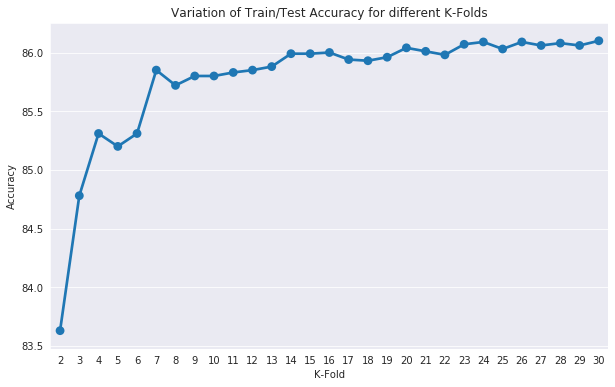

In [11]:
sns.set_style("darkgrid",
              {
                  'axes.grid' : True
              })
plt.figure(figsize=(10,6))
ax = sns.pointplot(x="K-Fold", y="Accuracy",data=df_knn_cv)
ax.set_title('Variation of Train/Test Accuracy for different K-Folds')

plt.savefig("output_knn_cv.png",dpi=150)

In [12]:
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
k_range = range(1,31)
param_grid = dict(n_neighbors=k_range)
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=10, scoring='accuracy')
#fit model to data
knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None, param_grid={'n_neighbors': range(1, 31)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [13]:
# examine the best model
print("Cross Validated K-Nearest Neighbour")
print('Accuracy:',str((knn_gscv.best_score_*100).round(2)) + '%')
print('Number of k-Nearest Neighbor:',knn_gscv.best_params_)

Cross Validated K-Nearest Neighbour
Accuracy: 85.8%
Number of k-Nearest Neighbor: {'n_neighbors': 3}


In [15]:
#create new a knn model
knn3 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
k_range = range(1,31)
weight_options = ['uniform', 'distance']
metric_options = ['euclidean','manhattan']
param_grid = dict(n_neighbors=k_range,weights=weight_options,metric=metric_options)
#use gridsearch to test all values for n_neighbors
knn_gscv2 = GridSearchCV(knn3, param_grid, cv=10, scoring='accuracy')
#fit model to data
knn_gscv2.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [16]:
# examine the best model
print("Cross Validated K-Nearest Neighbour and Distance")
print('Accuracy:',str((knn_gscv2.best_score_*100).round(2)) + '%')
print('Number of k-Nearest Neighbor:',knn_gscv2.best_params_)

Cross Validated K-Nearest Neighbour and Distance
Accuracy: 88.5%
Number of k-Nearest Neighbor: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}
